In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import dataset
df = pd.read_csv('.\\dataset\\train.csv')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


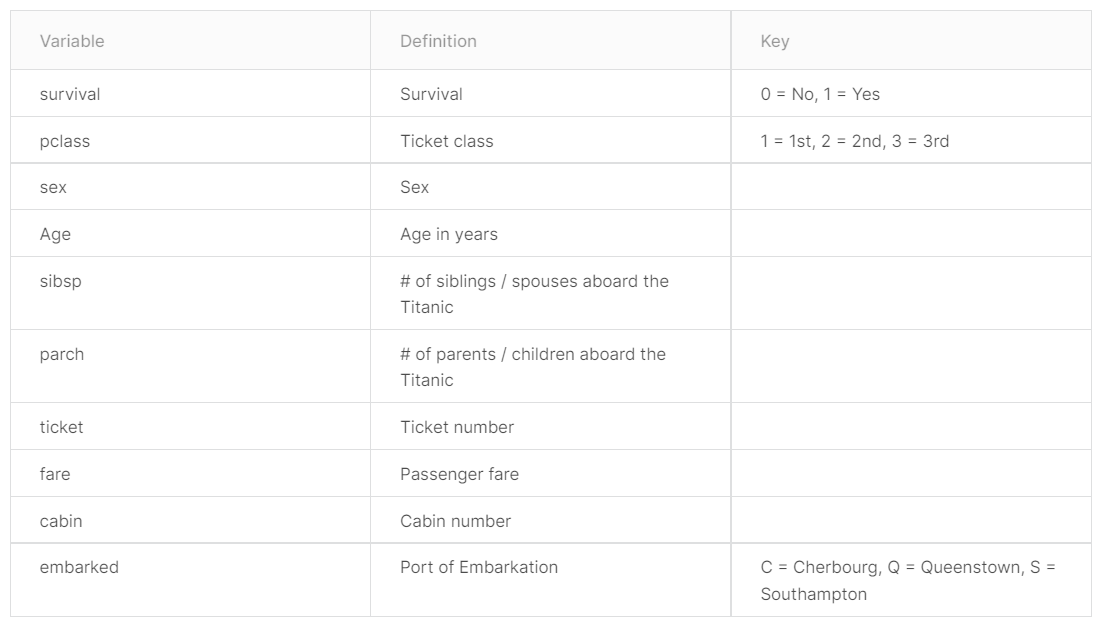

In [4]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
# Define columns in usage
target_col = ['Survived']
removed_features = ['PassengerId']
features = [col for col in list(df.columns) if col not in removed_features + target_col]

Identify numerical and categorical features

In [6]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']
cat_features = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

**Name, Ticket** features are removed because each passenger is likely to have an unique name and ticket number.

In [7]:
cat_features.remove('Name')
cat_features.remove('Ticket')

### A. Train/Test Split

Original dataset is splitted as followings: 

30% samples are selected randomly to test set and the remaining is train set

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.3, random_state=42)

In [9]:
# Train set
train_label = train_set[target_col]
train_cat = train_set[cat_features]
train_num = train_set[num_features]

# Test set
test_label = test_set[target_col]
test_cat = test_set[cat_features]
test_num = test_set[num_features]

### B. Base Model

Firstly, we need to develop a base-line model with minimum processing.

**Base-line model** is used to compare with other model versions then.

I select Logistic Regression - one of most popular models for classification as our base-line.

And to train the model, we need to ensure pre-requisites:
* Missing values were treated
* Categorical features were encoded to numerical values

#### 1. Categorical features encoding

* **Categorical encoding**

* Ordinal Encoder

In [10]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="constant", fill_value="Missing")
X_cat_array = imputer.fit_transform(train_set[cat_features])
X_cat_array[:5]

array([['male', 'A34', 'S'],
       ['male', 'Missing', 'S'],
       ['female', 'Missing', 'S'],
       ['male', 'Missing', 'S'],
       ['male', 'Missing', 'S']], dtype=object)

In [11]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
train_cat_ordinal = ordinal_encoder.fit_transform(X_cat_array)
X_cat_array = train_cat_ordinal
X_cat_array[:5]

array([[  1.,   8.,   3.],
       [  1., 105.,   3.],
       [  0., 105.,   3.],
       [  1., 105.,   3.],
       [  1., 105.,   3.]])

Name ordinal encoded categorical features

In [12]:
encoded_cat_features = cat_features

#### 2. Missing values treatment

After ordinal encoding, categorical features have no more missing values.

Therefore, we only handle missing values for numerical features now.

In [13]:
train_num.head()

,Age,SibSp,Parch,Fare,Pclass
445,4.0,0,2,81.8583,1
650,NaN,0,0,7.8958,3
172,1.0,1,1,11.1333,3
450,36.0,1,2,27.7500,2
314,43.0,1,1,26.2500,2


In [14]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_num_array = imputer.fit_transform(train_num)

In [15]:
imputer.statistics_

array([28.    ,  0.    ,  0.    , 14.4542,  3.    ])

In [16]:
train_num.median().values

array([28.    ,  0.    ,  0.    , 14.4542,  3.    ])

#### 3. Form train set to fit model

In [17]:
# Train Labels array
y_train_array = train_label.values
y_train_array.shape

(623, 1)

In [18]:
# Train features array
X_train_array = np.hstack((X_num_array, X_cat_array))
X_train_array.shape

(623, 8)

#### 4. Form test set to validate model later ####

We process data for test set following same steps as train set's

In [19]:
# Test Labels array
y_test_array = test_label.values
y_test_array.shape

(268, 1)

In [20]:
# Create transformation Pipeline for numerical features
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
 ])

In [21]:
# Create transformation Pipeline for categorical features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="constant", fill_value="Missing")),
    ('1hot', OrdinalEncoder()),
 ])

In [22]:
# Combine into one pipeline for all features
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features),
 ])

In [23]:
X_test_array = full_pipeline.fit_transform(test_set)
X_test_array.shape

(268, 8)

#### 5. Fit model ####

<b>Logistic Regression</b>
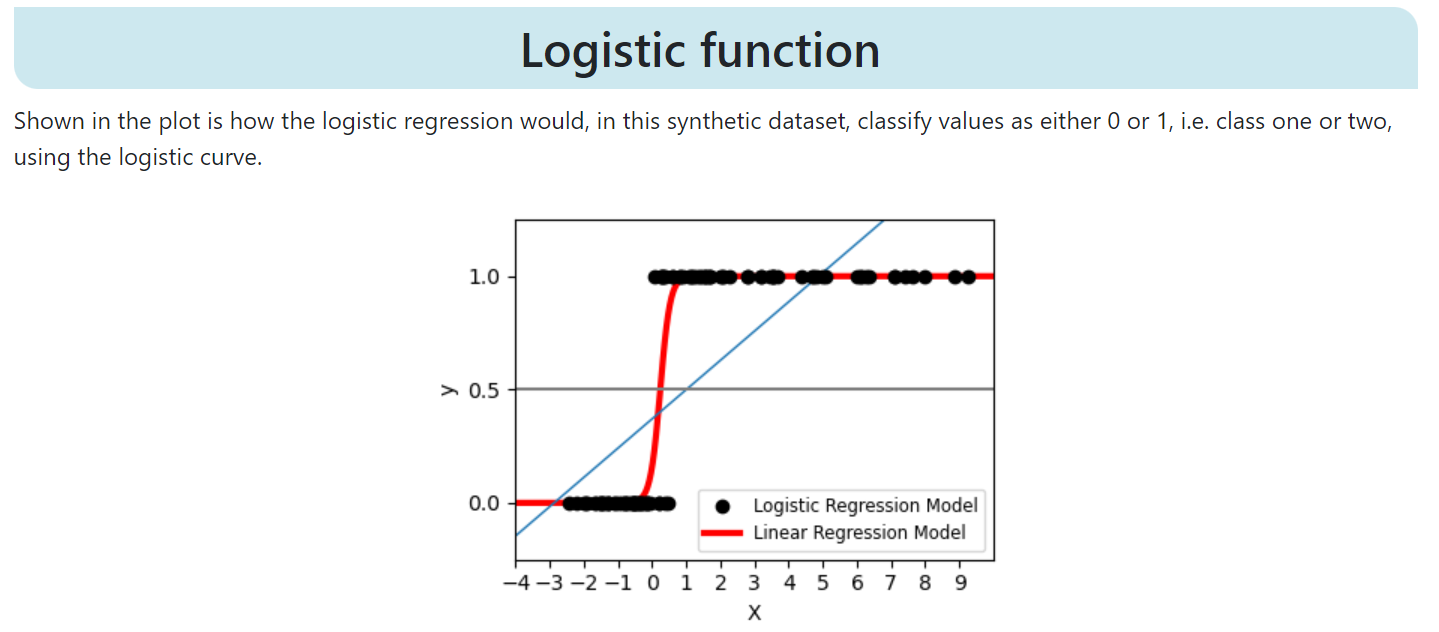

In [24]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(C=1e8)
logit.fit(X_train_array, y_train_array)

LogisticRegression(C=100000000.0)

In [25]:
logit.coef_

array([[-0.02001784, -0.32968802, -0.0152543 ,  0.00684202, -0.40103057,
        -2.75579087, -0.00297874, -0.14393812]])

In [26]:
logit.intercept_

array([3.23292469])

In [27]:
logit.predict_proba(X_train_array)

array([[0.48251834, 0.51748166],
       [0.8783628 , 0.1216372 ],
       [0.26963711, 0.73036289],
       ...,
       [0.9455312 , 0.0544688 ],
       [0.0773151 , 0.9226849 ],
       [0.61563215, 0.38436785]])

In [28]:
logit.classes_

array([0, 1], dtype=int64)

#### 6. Model validation with test set ####

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

test_scores = logit.decision_function(X_test_array)
test_auc_score = roc_auc_score(y_test_array, test_scores)
test_auc_score

0.8801285361794916

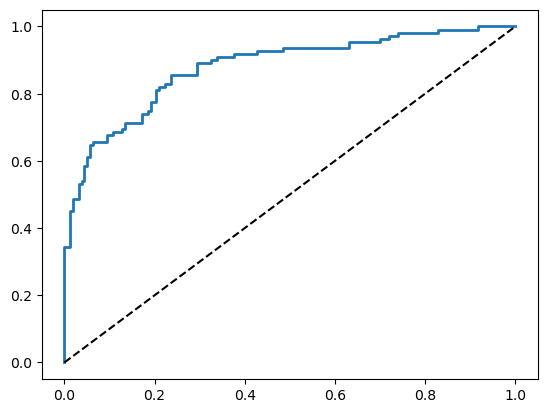

In [30]:
fpr, tpr, thresholds = roc_curve(y_test_array, test_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
plot_roc_curve(fpr, tpr)
plt.show()

To prevent overfitting effect from chosen test set, I use cross-validation to calculate the average AUC score across 10 random folds

In [31]:
from sklearn.model_selection import cross_val_score

def auc_score_cv10(model):
    train_model_scores = cross_val_score(model, X_train_array, y_train_array, 
                              scoring="roc_auc", cv=10)
    train_auc_cv10 = sum(train_model_scores)/len(train_model_scores)

    test_model_scores = cross_val_score(model, X_test_array, y_test_array, 
                              scoring="roc_auc", cv=10)
    test_auc_cv10 = sum(test_model_scores)/len(test_model_scores)
    return f'Train AUC Score Avg: {str(train_auc_cv10)}, Test AUC Score Avg: {str(test_auc_cv10)}'

In [32]:
base_model = logit
base_model_auc = auc_score_cv10(base_model)
base_model_auc

'Train AUC Score Avg: 0.8342823299888517, Test AUC Score Avg: 0.8658459595959596'

Note down these figures and see if we can improve later.

### C. Model Improvement
To impove model, we can consider the following actions:
* Get more data
* Create new features with better prediction
* Select right model
* Feature scaling (or other feature transformations e.g. log,...)
* Imputation (handle missing values)
* Grouping/Binning/Label encoding
* Remove multicolinearity (exclude features which are highly correlated with others)
* Remove outliers
* Regularization methods (e.g. Ridge, Lasso)
* Tuning Hyper-parameters

What we have at the moment:
* **Features**: 
    * num_features:
        * Imputer: 'median'
    * encoded_cat_features: 'ordinal'
* **Model**:
    * logit: 'Logistic Regression'

#### 1. Create new features

We can visualize correlation between independent features and target labels by using defined functions below:

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_plot(data, x, y, alpha):
    plt.scatter(x=data[x], y=data[y], alpha=alpha, c=data[x], cmap=plt.get_cmap("jet"), edgecolors='none')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar()

def bar_plot(data, x, y):
    tmp = data[[y, x]].groupby(by=x, as_index=False).agg(
        no_survival = (y, 'sum'),
        no_passenger = (y, 'count')
    )
    tmp['survival_percent'] = tmp['no_survival']/tmp['no_passenger']
    plt.bar(x=[str(value) for value in tmp[x]], height=tmp['survival_percent'], color=['red', 'green'])
    plt.yticks(np.arange(0, 1.2, 0.2))
    plt.xlabel(x)
    plt.ylabel('survival_percent')

Calculate the ratio of number of '1' and '0' in our train set.

In [34]:
labels_ratio = train_set.groupby(by='Survived', as_index=False).agg(
 cnt_obs = ('Survived', 'count')   
)
labels_ratio['ratio'] = labels_ratio['cnt_obs']/len(train_set)
labels_ratio

,Survived,cnt_obs,ratio
0,0,392,0.629213
1,1,231,0.370787


#### 1.1. 'AGE_GROUP'

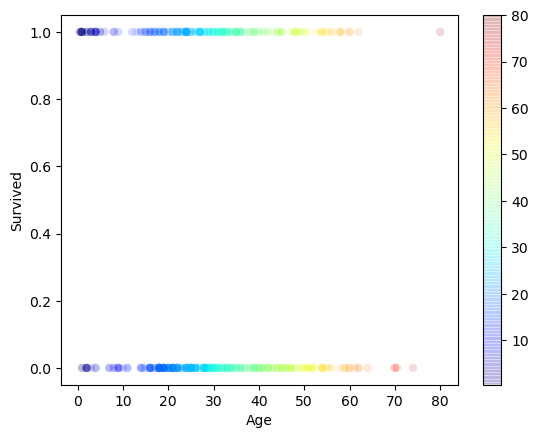

In [35]:
scatter_plot(train_set, x='Age', y='Survived', alpha=0.15)

It seems that the area of AGE under 18 are more densed in label '1' than '0'
* 0: Under 18
* 1: Other

age_group
1            540
0             83
dtype: int64

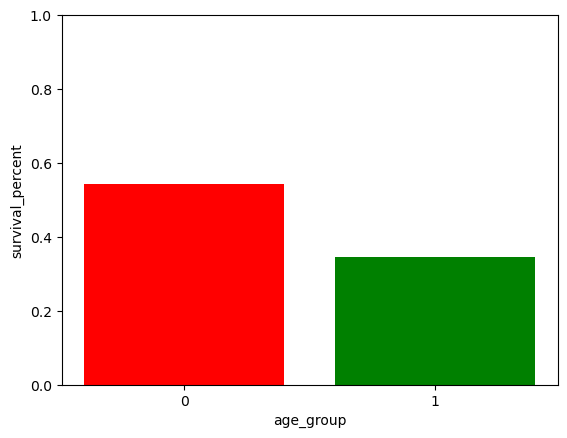

In [36]:
train_set['age_group'] = [0 if age < 18 else 1 for age in list(train_set['Age'])]
bar_plot(train_set, x='age_group', y='Survived')
train_set[['age_group']].value_counts()

#### 1.2. 'UPPER_FARE'

fare_groups   
(-1.0, 51.0]      513
(51.0, 102.0]      76
(102.0, 154.0]     20
(205.0, 256.0]      5
(256.0, 307.0]      4
(461.0, 512.0]      3
(154.0, 205.0]      2
(307.0, 359.0]      0
(359.0, 410.0]      0
(410.0, 461.0]      0
dtype: int64

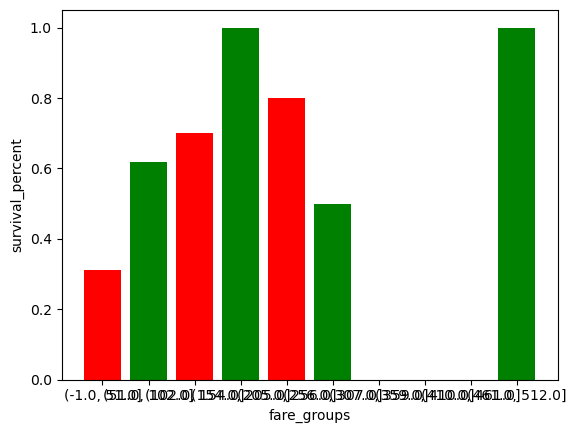

In [37]:
train_set['fare_groups'] = pd.cut(train_set['Fare'], bins=10, precision=0)
bar_plot(train_set, x='fare_groups', y='Survived')
train_set[['fare_groups']].value_counts()

upper_fare
0             513
1             110
dtype: int64

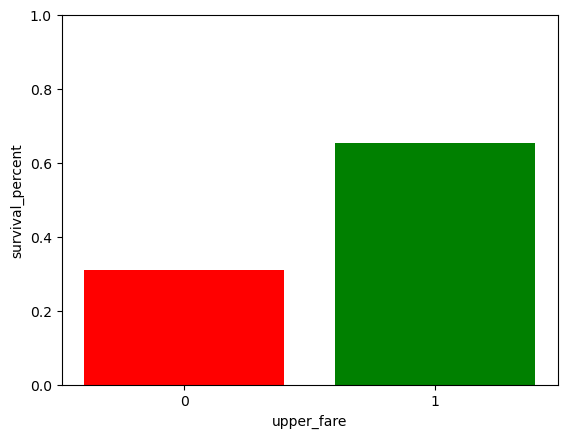

In [38]:
train_set['upper_fare'] = [0 if value < 51 else 1 for value in train_set['Fare']]
bar_plot(train_set, x='upper_fare', y='Survived')
train_set[['upper_fare']].value_counts()

I notice that 'Fare Under 51' have much lower survival rate than other groups. Therefore, I consider to add a new feature based on this finding to our model and remove the original 'Fare' if needed.

#### 1.3. 'CABIN_INFO_MISSING'

cabin_info_missing
0                     484
1                     139
dtype: int64

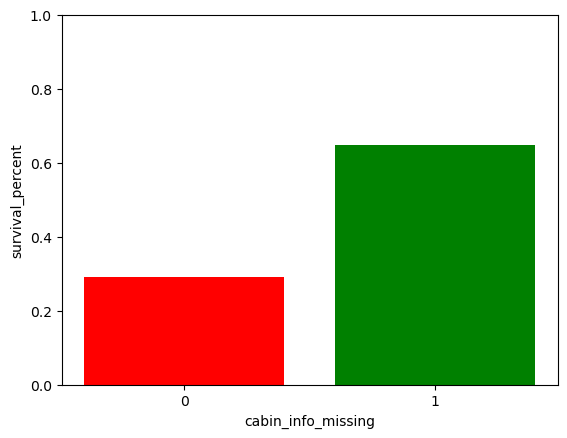

In [39]:
tmp = train_set[['Survived', 'Cabin']].fillna('Missing')
tmp['cabin_info_missing'] = [0 if Cabin == 'Missing' else 1 for Cabin in list(tmp['Cabin'])]
bar_plot(tmp, x='cabin_info_missing', y='Survived')
tmp[['cabin_info_missing']].value_counts()

Again, I notice that passengers with cabin information missing are less likely to survive from the disaster than others. However, when I test adding this feature in my model, the performance did not improve, so I decide to ignore this one and remove the original 'Cabin' because of significant missing.

For this notebook, I stop feature engineering here, you can utilize your understanding about disaster to come up with better features ideas. More advanced technique such as WoE transformation could be considered. 

In addition, I can look up at correlation values between individual features and target labels to identify least impacting features to remove from our model. In the correlation table below, 'Age', 'SibSp', 'Parch' show weak impacts, however, I only remove 'Parch' because only removal of this feature showed an improvement on my model.

In [40]:
train_set.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,age_group,upper_fare
PassengerId,1.000000,0.006853,-0.046089,0.031547,-0.083601,0.004945,0.019152,0.039711,0.007552
Survived,0.006853,1.000000,-0.312233,-0.078538,-0.049527,0.076756,0.239060,-0.139106,0.272036
Pclass,-0.046089,-0.312233,1.000000,-0.355026,0.097146,0.030596,-0.529208,-0.118898,-0.599154
Age,0.031547,-0.078538,-0.355026,1.000000,-0.319626,-0.190836,0.094097,0.640276,0.180163
SibSp,-0.083601,-0.049527,0.097146,-0.319626,1.000000,0.440442,0.154613,-0.303832,0.199566
Parch,0.004945,0.076756,0.030596,-0.190836,0.440442,1.000000,0.208619,-0.321277,0.117091
Fare,0.019152,0.239060,-0.529208,0.094097,0.154613,0.208619,1.000000,0.001067,0.688915
age_group,0.039711,-0.139106,-0.118898,0.640276,-0.303832,-0.321277,0.001067,1.000000,0.082440
upper_fare,0.007552,0.272036,-0.599154,0.180163,0.199566,0.117091,0.688915,0.082440,1.000000


* Add new features to **CombineAttributeAdder()**

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 add_age_group=False,
                 add_upper_fare=False,
                 add_cabin_info_missing=False): # no *args or **kargs
        self.add_age_group = add_age_group
        self.add_upper_fare = add_upper_fare
        self.add_cabin_info_missing = add_cabin_info_missing
        
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        if self.add_age_group:
            X['age_group'] = [0 if age < 18 else 1 for age in X['Age']]
        if self.add_upper_fare:
            X['upper_fare'] = [0 if value < 51 else 1 for value in X['Fare']]
        if self.add_cabin_info_missing:
            tmp = X[['Cabin']].fillna('Missing')
            X['cabin_info_missing'] = [0 if value == 'Missing' else 1 for value in list(tmp['Cabin'])]
        return X

* Add removed features to **CombineAttributeRemover()**

In [42]:
class CombinedAttributesRemover(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 del_age=False,
                 del_fare=False,
                 del_embarked=False,
                 del_parch=False,
                 del_sibsp=False,
                 del_cabin=False): # no *args or **kargs
        self.del_age = del_age
        self.del_fare = del_fare
        self.del_embarked = del_embarked
        self.del_parch=del_parch
        self.del_sibsp=del_sibsp
        self.del_cabin=del_cabin
        
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        if self.del_age:
            X.drop('Age', axis=1, inplace=True)
        if self.del_fare:
            X.drop('Fare', axis=1, inplace=True)
        if self.del_embarked:
            X.drop('Embarked', axis=1, inplace=True)
        if self.del_parch:
            X.drop('Parch', axis=1, inplace=True)
        if self.del_sibsp:
            X.drop('SibSp', axis=1, inplace=True)
        if self.del_cabin:
            X.drop('Cabin', axis=1, inplace=True)
        return X

Define pipeline for features processing, which contains:

* One pipeline to process numerical features:
    1. Add new features: 'upper_fare'
    2. Remove features: 'Fare', 'Parch'
    3. Replace missing values with median values
    4. Standard Scaling (served to SVM)

...
* One pipeline to process categorical features:
    1. Remove features: 'Embarked', 'Cabin'
    2. Replace missing values with a constant value
    3. Ordincal encoding

In [43]:
def roc_auc(model, X_array, y_array):
    y_score = model.predict_proba(X_array)
    fpr, tpr, _ = roc_curve(y_array, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [44]:
# Create transformation Pipeline for numerical features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('features_adder', CombinedAttributesAdder(add_age_group=True, 
                                               add_upper_fare=True)),
    ('features_remover', CombinedAttributesRemover(del_age=False,
                                                   del_fare=True,
                                                   del_parch=True,
                                                   del_sibsp=False)),
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
 ])

# Create transformation Pipeline for categorical features
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

cat_pipeline = Pipeline([
    ('features_adder', CombinedAttributesAdder(add_cabin_info_missing=False)),
    ('features_remover', CombinedAttributesRemover(del_embarked=True,
                                                   del_cabin=True)),
    ('imputer', SimpleImputer(strategy="constant", fill_value="Missing")),
    ('ordinal', OrdinalEncoder()),
    # ('1hot', OneHotEncoder()),
 ])

# Combine into one pipeline for all features
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features),
 ])

# Test Labels array
y_train_array = train_label.values
X_train_array = full_pipeline.fit_transform(train_set)

Apply defined processing pipeline above to test set:

In [45]:
# Form test set
y_test_array = test_label.values
X_test_array = full_pipeline.fit_transform(test_set[num_features + cat_features])

Fitting train set with different models:
* Logistic Regression
* Decision Tree
* Random Forest
* Support Vector Machine
* AdaBoost

In [46]:
# Fit model
### Logistic Regression
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(C=1e8)
logit.fit(X_train_array, y_train_array)

## Decision Tree
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=42)
tree_clf.fit(X_train_array, y_train_array)

## Random Forest
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=50, max_depth=3, min_samples_leaf=10, random_state=42)
forest_clf.fit(X_train_array, y_train_array)

## Support Vector Machine
from sklearn.svm import SVC

# svm_clf = SVC(kernel="poly", degree=2, coef0=1, C=5)
svm_clf = SVC(kernel="rbf", gamma=1, C=0.001)
svm_clf.fit(X_train_array, y_train_array)

## AdaBoost
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3), n_estimators=50,
    algorithm="SAMME", learning_rate=0.1, random_state=42
)
ada_clf.fit(X_train_array, y_train_array)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.1, random_state=42)

Evaluate models' AUC score with cross-validation of 10 folds and compare with **base_model**:

In [47]:
base_model_auc

'Train AUC Score Avg: 0.8342823299888517, Test AUC Score Avg: 0.8658459595959596'

In [48]:
auc_score_cv10(logit)

'Train AUC Score Avg: 0.8425241545893719, Test AUC Score Avg: 0.8838320707070706'

In [49]:
auc_score_cv10(tree_clf)

'Train AUC Score Avg: 0.8172273318468971, Test AUC Score Avg: 0.8520391414141413'

In [50]:
auc_score_cv10(forest_clf)

'Train AUC Score Avg: 0.8437834448160535, Test AUC Score Avg: 0.8659027777777778'

In [51]:
auc_score_cv10(svm_clf)

'Train AUC Score Avg: 0.8366211445559273, Test AUC Score Avg: 0.8755744949494948'

In [52]:
auc_score_cv10(ada_clf)

'Train AUC Score Avg: 0.8516796729840209, Test AUC Score Avg: 0.8684343434343436'

### D. Conclusion

After performing some basic steps tuning my model.

Logistic Regression showed the best outcome on test set with AUC score of 0.8838.

However, AdaBoost showed a more stable model with high and similar AUC score on both train and test set, at 0.8516 and 0.8684 respectively.

This notebook is not perfect. You can perform further actions to create more powerful model.